In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [3]:
pwd

'/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac'

In [4]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [5]:
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_sample_10000.h5ad'
os.path.exists(atac_path)

True

In [6]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [7]:
adata

AnnData object with n_obs × n_vars = 10000 × 10000
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

In [8]:
n_sample_cells = 650
n_sample_peaks = n_sample_cells * 2

In [9]:
adata.shape

(10000, 10000)

In [10]:
np.random.seed(100)

adata = adata[:,adata.var.modality == 'ATAC'].copy()
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [11]:
adata.shape

(650, 1300)

In [12]:
adata

View of AnnData object with n_obs × n_vars = 650 × 1300
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

In [13]:
print('here...')

here...


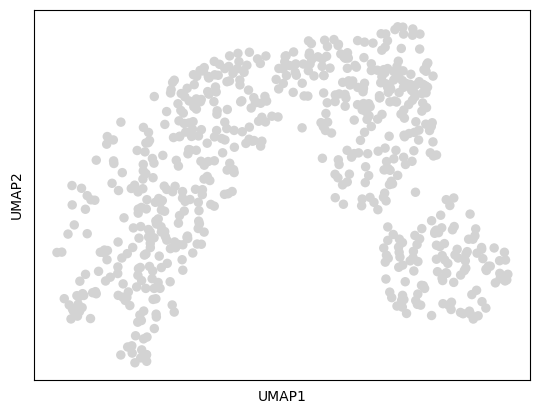

In [14]:
sc.pl.umap(adata)

In [15]:
adata.var

,modality
1-9742682-9743370,ATAC
1-14298257-14298915,ATAC
1-19901610-19902428,ATAC
1-28185335-28186301,ATAC
1-32553666-32554595,ATAC
...,...
X-142383120-142384028,ATAC
X-153476465-153477353,ATAC
X-164990455-164991371,ATAC
X-166440250-166441148,ATAC


In [16]:
adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]
adata.var['start'] = adata.var_names.str.split('-').str[1].astype(int)
adata.var['end'] = adata.var_names.str.split('-').str[2].astype(int)

In [17]:
extend = 50

adata.var['chr'].value_counts()

chr4     96
chr5     95
chr1     93
chr2     87
chr6     84
chr3     82
chr11    73
chr7     73
chr9     67
chr10    67
chr12    66
chr14    61
chr8     60
chr16    53
chr13    49
chr15    48
chr17    44
chr19    37
chrX     33
chr18    32
Name: chr, dtype: int64

In [18]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [19]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [20]:
adata.shape

(650, 1300)

In [21]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmpaftxq1wq
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpaftxq1wq -fo /tmp/tmpmjfc66uc


In [22]:
len(seqs)

1300

In [23]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [24]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break


next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

next_data_sel

del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(1299, 650)

In [25]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [26]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(844350, 3)
650
0      1299
137    1299
127    1299
128    1299
129    1299
       ... 
69     1299
70     1299
71     1299
72     1299
199    1299
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
GCCCAATGAAGCGCGAGTTCCACCTTCTCGGGGCGGCTCTAGGATGAGAGTGACGGCTCTGATCAGTCACGTGGCCTTGAGGGCGGAGCCTATGAAAATT,1.0,3.0,0
GCTCACTACCAAGACCCCGCCTCCTCAGAAGAGCTTCACCGGAAGAGCAGTTCGCTGCAGGCCCCGCCCACATTTCTTGGGATCCGTTCTGAAAACAGCA,1.0,4.0,0
TGCAGGACCTCGAGGTCCTCTAGTCACACGGGACAAGGCAGGGTTCGGGAGTTGGGGCCTGAGCTGCTCCTTGGCCTGTAAAAGCGGGTTGCTGGGCGGA,1.0,0.0,0
CCTCCCACCTGGCTCTAGCCCCGCCTCCCGCCAGGCCCCGCCTCCTGCCGGGCTATATCTTCCCCCCCCCCCAACCCCCCACATCCCGCCCCGCCCTCCC,1.0,1.0,0
TAGGTCGCGGGGGGGCGGACCTACTCCCGTCCAGCCTTATTGCCATTTCCATTGGTCAGATTTTTTGTCATTCAAGTAACTTCGCGGACATAGGCGCAAG,1.0,3.0,0


### This is the relatedness graph and used for dynamics filters learning

In [27]:
# sum(adata.obs_names.isin(df.index)

In [28]:
len(seqs)

1300

In [29]:
conn_sparse = adata[:,~zero_counts].uns['neighbors']['connectivities']
conn_sparse

<650x650 sparse matrix of type '<class 'numpy.float32'>'
	with 600 stored elements in Compressed Sparse Row format>

In [30]:
rel = conn_sparse.A
# rel[:n_cells,:n_cells].sum()
rel.shape

(650, 650)

In [31]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [32]:
n_batch = len(set(dataset.batch))
n_batch

1

In [33]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [34]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [35]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [36]:
n_kernels = 5

In [37]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

w = [20 for i in range(n_kernels - 2)]
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=False,
                                       optimize_log_dynamic=True,
                                       use_dinuc=False,
                                       device=device,
                                       prepare_knn=True,
                                       adata=adata,
                                       dinuc_mode=None)# .cuda()



setting up log dynamic


In [38]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

binding_modes.prob_act True
binding_modes.conv_mono.1.weight True
binding_modes.conv_mono.2.weight True
binding_modes.conv_mono.3.weight True
binding_modes.conv_mono.4.weight True
activities.log_activities.0 True
activities.log_activities.1 True
activities.log_activities.2 True
activities.log_activities.3 True
activities.log_activities.4 True
graph_module.log_etas True
graph_module.log_dynamic True


In [40]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            skip_kernels=range(3, 100),
                                            early_stopping=50, log_each=2, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch:  3, Loss: 0.185367, R2: 0.32,  best epoch: 0,  secs per epoch: 1.189 s,  secs epoch*1k trials: 0.915s curr time: 2023-07-06 09:40:03.198897
Epoch:  5, Loss: 0.182303, R2: 0.32,  best epoch: 3,  secs per epoch: 1.080 s,  secs epoch*1k trials: 0.831s curr time: 2023-07-06 09:40:05.140200
Epoch:  7, Loss: 0.187093, R2: 0.32,  best epoch: 4,  secs per epoch: 0.965 s,  secs epoch*1k trials: 0.743s curr time: 2023-07-06 09:40:06.614000
Epoch:  9, Loss: 0.180413, R2: 0.32,  best epoch: 4,  secs per epoch: 0.908 s,  secs epoch*1k trials: 0.699s curr time: 2023-07-06 09:40:08.083983
Epoch: 11, Loss: 0.187168, R2: 0.32,  best epoch: 8,  secs per epoch: 0.895 s,  secs epoch*1k trials: 0.689s curr time: 2

True
5
order None
0 out of 5...
done with mono


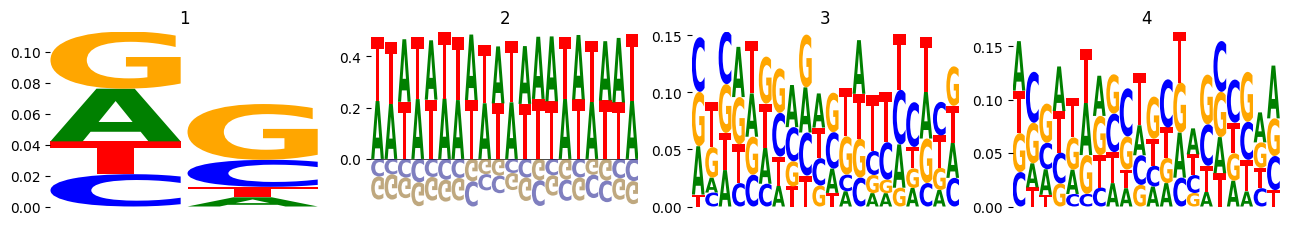

In [ ]:
from matplotlib import rcParams
n_cols = len(model.binding_modes)
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.logo(model, show=True) #  n_cols=int(n_cols / 2), n_rows=2)
plt.show()


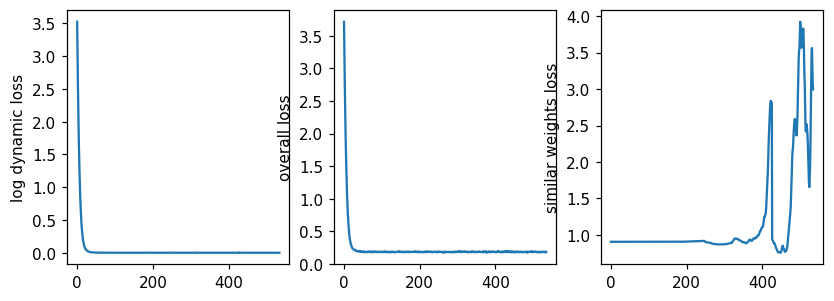

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.show()

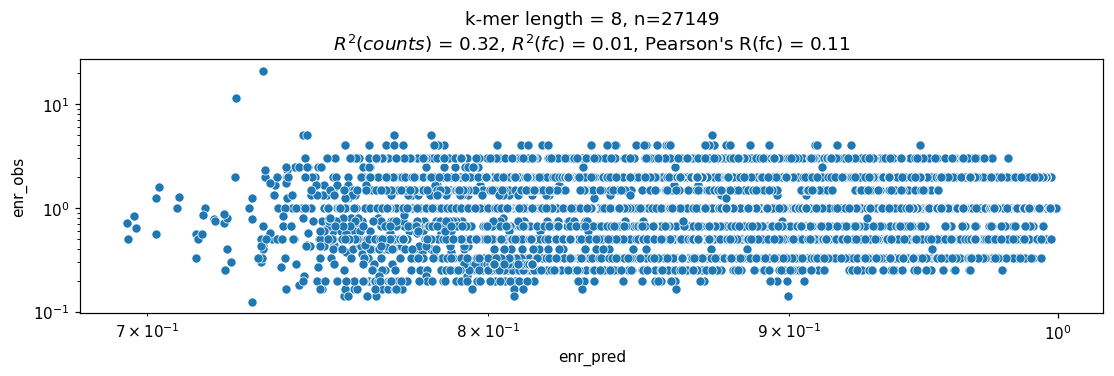

{'r2_counts': 0.3230619641464483,
 'r2_foldchange': 0.0108328465518851,
 'r2_enr': -0.05209003823759395,
 'r2_fc': 0.012743648252144833,
 'pearson_foldchange': 0.11288776839031248}

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [6, 3], 'figure.dpi': 110})
mb.pl.kmer_enrichment(model, train, style='scatter', k=8)

In [ ]:
log_dynamic.max()

NameError: name 'log_dynamic' is not defined

<AxesSubplot: >

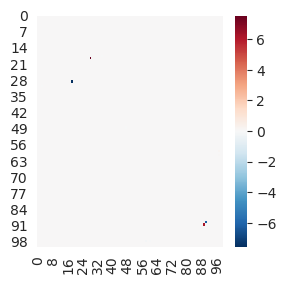

In [ ]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

<AxesSubplot: xlabel='index', ylabel='r2'>

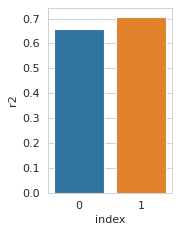

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [ ]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [ ]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

Text(0.5, 7.555555555555548, 'dynamic score (normalized)')

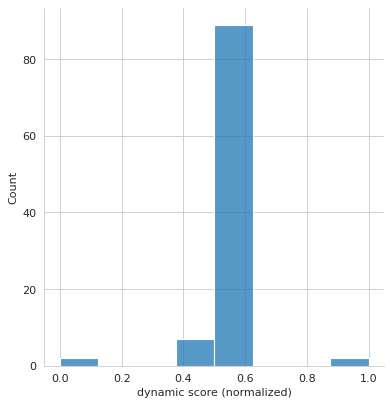

In [ ]:
adata.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

adata.obs['dynamic_score_z1'] = z1
adata.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score)
plt.xlabel('dynamic score (normalized)')


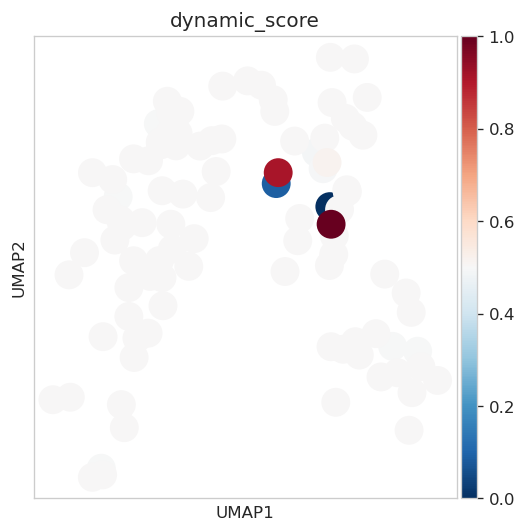

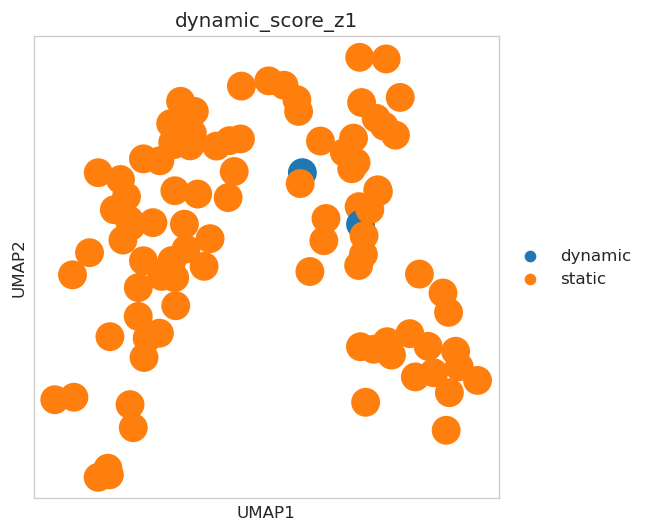

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(adata, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [ ]:
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

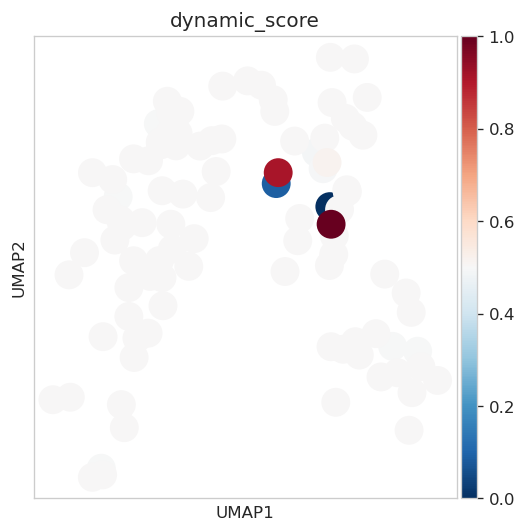

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='dynamic_score', cmap='RdBu_r', sort_order=True)


In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 90
sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

LinAlgError: 2-th leading minor of the array is not positive definite

In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
